# Gold Price Prediction Modeling Phase

This notebook builds an LSTM model using our preprocessed datasets to predict the next day's high / low.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

## RF dataset implementation

In [2]:
# Load the dataset
#df_rfe = pd.read_csv("../data/processed/dataset_RFE.csv", parse_dates=["date"])
df_rfe = pd.read_csv("../data/processed/dataset_RF.csv", parse_dates=["date"])
#df_rfe = pd.read_csv("../data/processed/dataset_MI.csv", parse_dates=["date"])
df_rfe = df_rfe.sort_values("date")

df_rfe.tail()

,date,oil_close,volume,dxy_close,rsi_14,ema_200,next_open,high,low,target
2294,2025-02-20,0.455510,-0.157693,1.519260,0.987063,2.716108,3.105136,3.107683,3.106356,-0.731591
2295,2025-02-21,0.345289,-0.160621,1.571142,1.104501,2.726444,3.091162,3.069191,3.089340,0.845515
2296,2025-02-24,0.364107,-0.165898,1.569220,1.038398,2.736968,3.104891,3.112798,3.128305,-1.657194
2297,2025-02-25,0.269478,-0.116905,1.513496,0.318775,2.746165,3.043111,3.076987,3.022013,0.120130
2298,2025-02-26,0.243133,-0.110232,1.534633,0.268888,2.755618,3.055369,3.013159,3.078735,-1.648110


## Train Test split
We split our dataset as it follows:
- Train: 7 first years of the dataset
- Test: Last 2+ years of the dataset

In [3]:
# Set the training end date to December 31, 2022
train_end_date = pd.Timestamp("2022-12-31")

# Split the data using the fixed date
train_data = df_rfe[df_rfe["date"] <= train_end_date]
test_data = df_rfe[df_rfe["date"] > train_end_date]

print("Training period:", train_data["date"].min(), "to", train_data["date"].max())
print("Testing period:", test_data["date"].min(), "to", test_data["date"].max())

Training period: 2016-01-04 00:00:00 to 2022-12-30 00:00:00
Testing period: 2023-01-03 00:00:00 to 2025-02-26 00:00:00


## Prepare Data for LSTM

We will create sequences of a fixed window size from our dataset. Each sequence will contain past values for our features, and the corresponding target will be the next day's value.

In [4]:
# Function to create sequences for LSTM
def create_sequences(data, features, target, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[features].iloc[i:i+window_size].values)
        y.append(data[target].iloc[i+window_size])
    return np.array(X), np.array(y)

# Define feature columns
features = df_rfe.columns.difference(["date", "target"]).tolist()
target = "target"

# Set the lookback window size (3 months of trading days)
window_size = 63

## Create sequences from Train Test data
We split the sequences into training and testing sets using an 80/20 split (keeping the time order).

In [5]:
# Create sequences for training and testing datasets
X_train, y_train = create_sequences(train_data, features, target, window_size)
X_test, y_test = create_sequences(test_data, features, target, window_size)

print("Training sequences shape:", X_train.shape, y_train.shape)
print("Testing sequences shape:", X_test.shape, y_test.shape)

Training sequences shape: (1696, 63, 8) (1696,)
Testing sequences shape: (477, 63, 8) (477,)


## Scale the Target Variable

We scale the target using StandardScaler to help the model learn more effectively. We'll inverse-transform the predictions later for evaluation.## Scale the Target Variable

In [6]:
# Initialize the scaler for the target variable
target_scaler = StandardScaler()

# Reshape target arrays to 2D for scaling
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))

## Build and Train the LSTM Model

In [8]:
# Build the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(window_size, len(features))),
    #LSTM(100),
    LSTM(100),
    #Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.3)

Epoch 1/100
19/19 [==============================] - 2s 80ms/step - loss: 1.1238 - val_loss: 1.0753
Epoch 2/100
19/19 [==============================] - 1s 61ms/step - loss: 1.1081 - val_loss: 1.0717
Epoch 3/100
19/19 [==============================] - 1s 60ms/step - loss: 1.0971 - val_loss: 1.0773
Epoch 4/100
19/19 [==============================] - 1s 61ms/step - loss: 1.0919 - val_loss: 1.0730
Epoch 5/100
19/19 [==============================] - 1s 61ms/step - loss: 1.0920 - val_loss: 1.0788
Epoch 6/100
19/19 [==============================] - 1s 59ms/step - loss: 1.0926 - val_loss: 1.0913
Epoch 7/100
19/19 [==============================] - 1s 61ms/step - loss: 1.0890 - val_loss: 1.0767
Epoch 8/100
19/19 [==============================] - 1s 62ms/step - loss: 1.0897 - val_loss: 1.0754
Epoch 9/100
19/19 [==============================] - 1s 58ms/step - loss: 1.0874 - val_loss: 1.0768
Epoch 10/100
19/19 [==============================] - 1s 59ms/step - loss: 1.0813 - val_loss: 1.0879

## Evaluate the Model

15/15 [==============================] - 0s 12ms/step
y_pred_scaled shape before reshape: (477, 1)
y_pred_scaled shape after reshape: (477, 1)
Final y_pred_scaled shape: (477, 1)
Test RMSE: 1.0800694993429172
Test MAE: 0.8593258775107186


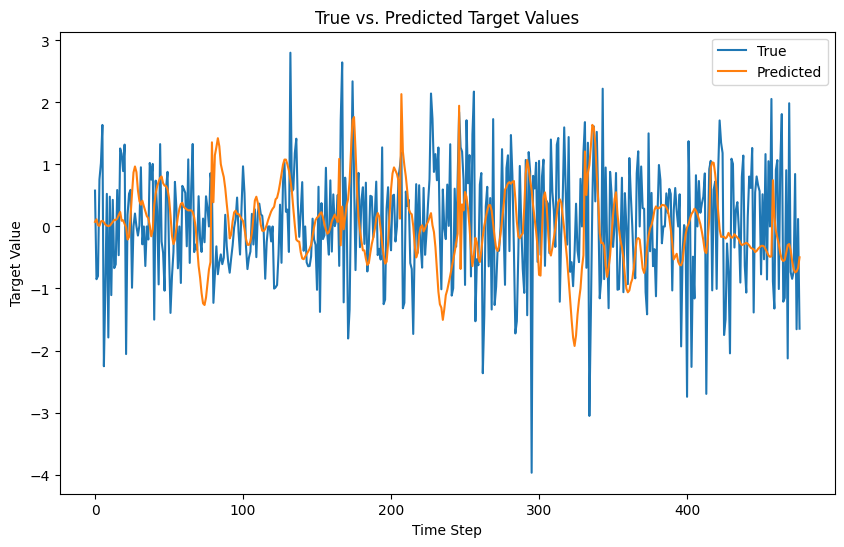

In [9]:
# Predict on the test set
y_pred_scaled = model.predict(X_test)
print("y_pred_scaled shape before reshape:", y_pred_scaled.shape)

# If the prediction has three dimensions, reshape it to 2D
if y_pred_scaled.ndim == 3:
    y_pred_scaled = y_pred_scaled.reshape(y_pred_scaled.shape[0], -1)
print("y_pred_scaled shape after reshape:", y_pred_scaled.shape)

# If the number of columns is not 1, assume the correct prediction is in the last column
if y_pred_scaled.shape[1] != 1:
    y_pred_scaled = y_pred_scaled[:, -1].reshape(-1, 1)
print("Final y_pred_scaled shape:", y_pred_scaled.shape)

# Inverse-transform the scaled values
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_inv = target_scaler.inverse_transform(y_test_scaled)

# Compute RMSE and MAE
rmse = root_mean_squared_error(y_test_inv, y_pred)
mae = mean_absolute_error(y_test_inv, y_pred)
print("Test RMSE:", rmse)
print("Test MAE:", mae)

# Plot true vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='True')
plt.plot(y_pred, label='Predicted')
plt.title("True vs. Predicted Target Values")
plt.xlabel("Time Step")
plt.ylabel("Target Value")
plt.legend()
plt.show()

#### The above plot shows the values in terms of percentage change around the open price for each day. The last cell in the notebook shows the predicted vs. actual values in terms of actual prices

## Add predictions column to the dataset and save it to a csv file

In [10]:
# Load the clean dataset that contains full OHLC data
gold_prices_df = pd.read_csv("../data/processed/gold_ohlc.csv", parse_dates=["date"])

# Select the necessary columns for backtesting (OHLC and volume)
ohlc_df = gold_prices_df[["date", "open", "high", "low", "close", "volume"]].copy()

# Extract the corresponding dates:
test_dates = test_data["date"].iloc[window_size:].reset_index(drop=True)

# Create a DataFrame for predictions. It includes the date, true target, and predicted target.
predictions_df = pd.DataFrame({
    "date": test_dates,
    "unscaled_target": y_test_inv.flatten(),
    "unscaled_prediction": y_pred.flatten()
})

# Merge OHLC data with the predictions on the 'date' column.
final_backtest_df = pd.merge(ohlc_df, predictions_df, on="date", how="inner")

# Convert the true_target and prediction from percentages to original values.
final_backtest_df["next_days_target"] = final_backtest_df["open"] * (final_backtest_df["unscaled_target"] / 100)
final_backtest_df["next_days_prediction"] = final_backtest_df["open"] * (final_backtest_df["unscaled_prediction"] / 100)
final_backtest_df["target"] = final_backtest_df["next_days_target"].shift(+1) + final_backtest_df["open"]
final_backtest_df["prediction"] = final_backtest_df["next_days_prediction"].shift(+1) + final_backtest_df["open"]

final_backtest_df = final_backtest_df.drop(columns=["unscaled_target", "unscaled_prediction", "next_days_target", "next_days_prediction"], axis=1)
final_backtest_df.dropna(inplace=True)

# Save the final backtest dataset to CSV for use in the backtesting module.
final_backtest_df.to_csv("../data/processed/backtest_data_final.csv", index=False)

## Plot Predicted Vs. Actual values

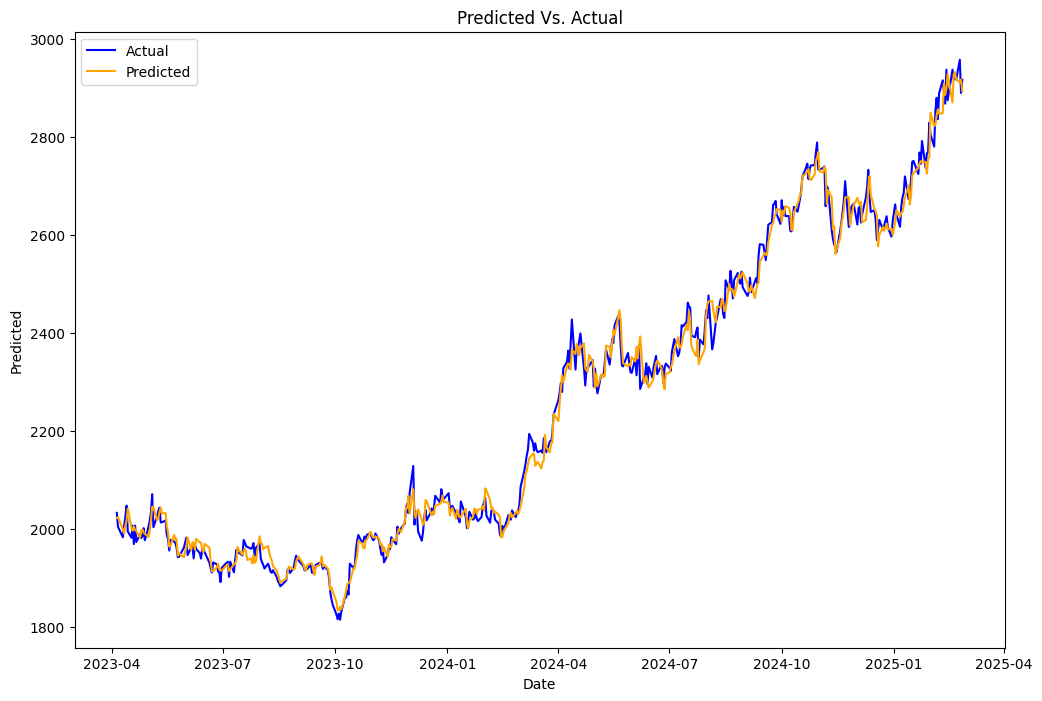

In [11]:
plt.figure(figsize=(12,8))
plt.plot(final_backtest_df["date"], final_backtest_df["target"], label="Actual", color="blue")
plt.plot(final_backtest_df["date"], final_backtest_df["prediction"], label="Predicted", color="orange")
plt.title("Predicted Vs. Actual")
plt.xlabel("Date")
plt.ylabel("Predicted")
plt.legend()
plt.show()